In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

#SKLearn stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('data/kc_house_data.csv')

# Header cleaning. More precautionary than anything else
df.columns = [x.strip().lower().replace(' ','').replace('-','') for x in df.columns]
df.drop(columns = ['id'],inplace = True)
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
# Removing outliers
df = df[df['bedrooms'] <=15] #Only 1 record remove. 33 Bed, 1.75 Bath?

sqft_basement is an object?

In [6]:
df.sqft_basement.sort_values()

0        0.0
12644    0.0
12645    0.0
12646    0.0
12648    0.0
        ... 
2126       ?
8548       ?
4776       ?
15185      ?
8565       ?
Name: sqft_basement, Length: 21596, dtype: object

sqft_basement is a list of strings that include some unknowns marked as '?'

In [7]:
df_subset_basement = df[df.sqft_basement !='?'] #drop records where sqft_basement is not '?'
df_subset_basement.sqft_basement = df_subset_basement.sqft_basement.astype(float,)

In [8]:
#check to see how much of the current sqft_basement (excluding '?') can be explained by (sqft_living-sqft_above)

(df_subset_basement.sqft_living - df_subset_basement.sqft_above == df_subset_basement.sqft_basement).sum()/df_subset_basement.shape[0]

1.0

turns out 100%. Fill na using this math

In [9]:
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [10]:
# Change view rating to a numeric value. Probably don't need it
df['view'] = df['view'].map({'EXCELLENT':5,
                             'GOOD':4,
                             'AVERAGE':3,
                             'FAIR':2,
                             'NONE':1})

# Change condition rating to a numeric value. Probably don't need it
df['condition'] = df['condition'].map({'Very Good':5,
                                       'Good':4,
                                       'Average':3,
                                       'Fair':2,
                                       'Poor':1})

# Changing grade to just the numeric value of the grade
df['grade'] = df['grade'].str.split(' ').str[0].astype(int)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21596 non-null  object 
 1   price          21596 non-null  float64
 2   bedrooms       21596 non-null  int64  
 3   bathrooms      21596 non-null  float64
 4   sqft_living    21596 non-null  int64  
 5   sqft_lot       21596 non-null  int64  
 6   floors         21596 non-null  float64
 7   waterfront     19220 non-null  object 
 8   view           21533 non-null  float64
 9   condition      21596 non-null  int64  
 10  grade          21596 non-null  int32  
 11  sqft_above     21596 non-null  int64  
 12  sqft_basement  21596 non-null  int64  
 13  yr_built       21596 non-null  int64  
 14  yr_renovated   17754 non-null  float64
 15  zipcode        21596 non-null  int64  
 16  lat            21596 non-null  float64
 17  long           21596 non-null  float64
 18  sqft_l

In [12]:
#The number of records where view is nan is 0.29% of the dataset. Hence dropped
print(df.view.isna().sum() /df.shape[0])
df.dropna(subset=['view'],inplace=True)

0.0029172068901648454


In [13]:
df.corr().price.sort_values()

zipcode         -0.053626
long             0.022428
condition        0.035367
yr_built         0.054284
sqft_lot15       0.083194
sqft_lot         0.090341
yr_renovated     0.129890
floors           0.257069
lat              0.307863
bedrooms         0.315236
sqft_basement    0.321812
view             0.395739
bathrooms        0.525063
sqft_living15    0.585329
sqft_above       0.605719
grade            0.668320
sqft_living      0.701599
price            1.000000
Name: price, dtype: float64

dropping yr_renovated,floors,yr_built

In [14]:
df = df.drop(columns = ['yr_renovated','yr_built','floors','date'],axis =1)

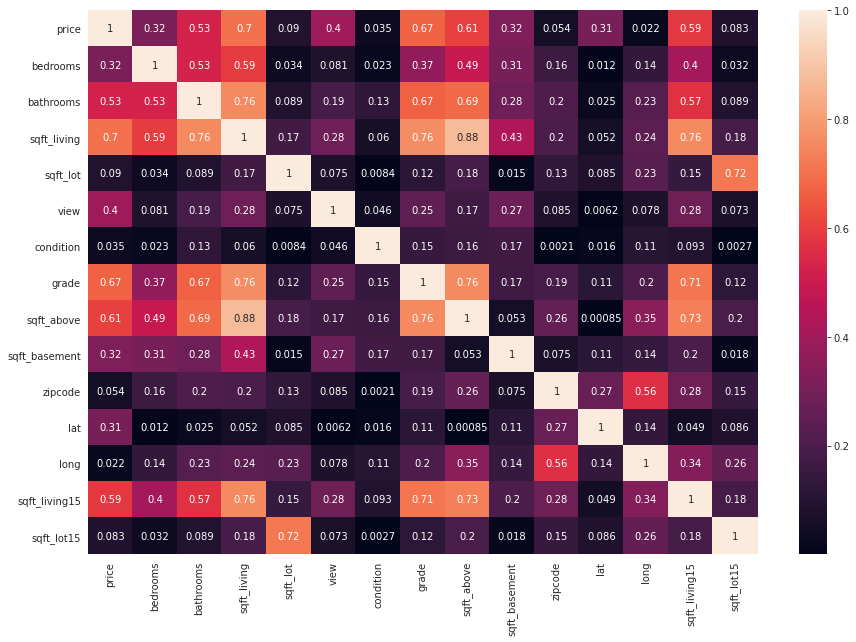

In [15]:
# sns.heatmap(df.corr(),annot=True)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(abs(df.corr()),annot=True)

Note the corelation between
- sqft_living and sqft_above (because sqft_living = sqft_above + sqft_basement). In fact a lot of the sqft are highly corelated
    - try feature engineering between them, or just pick 1 or 2
- grade to sqft_living15, sqft_above
- bathrooms to grade
- grade and sqft_living has highest impact on target (price)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21533 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21533 non-null  float64
 1   bedrooms       21533 non-null  int64  
 2   bathrooms      21533 non-null  float64
 3   sqft_living    21533 non-null  int64  
 4   sqft_lot       21533 non-null  int64  
 5   waterfront     19163 non-null  object 
 6   view           21533 non-null  float64
 7   condition      21533 non-null  int64  
 8   grade          21533 non-null  int32  
 9   sqft_above     21533 non-null  int64  
 10  sqft_basement  21533 non-null  int64  
 11  zipcode        21533 non-null  int64  
 12  lat            21533 non-null  float64
 13  long           21533 non-null  float64
 14  sqft_living15  21533 non-null  int64  
 15  sqft_lot15     21533 non-null  int64  
dtypes: float64(5), int32(1), int64(9), object(1)
memory usage: 2.7+ MB


In [17]:
df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
waterfront       2370
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### Train Test split

In [18]:
# Define our X and y
X = df.drop(columns='price')
y = df['price']

In [19]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42)

### Model 0. Linear Regression using highest corr coefficient feature: sqft_living

In [20]:
cols = ['sqft_living']

In [21]:
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [22]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train)  # apply scaling on training data
pipe.score(X_test_subset, y_test)

0.4991663998577013

###  Model 1 : Sqft_living, grade

In [23]:
cols = ['sqft_living','grade']

In [24]:
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [25]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train)  # apply scaling on training data
pipe.score(X_test_subset, y_test)

0.5422895634708242

### Model 2: Sqft_living/Sqft_living15, grade

In [26]:
cols = ['sqft_living','sqft_living15','grade']

In [27]:
X_train_subset = X_train[cols]
X_train_subset['sqft_living / sqft_living15'] = X_train_subset['sqft_living'] / X_train_subset['sqft_living15']
X_train_subset.drop(columns = ['sqft_living', 'sqft_living15'],inplace = True)

In [28]:
X_test_subset = X_test[cols]
X_test_subset['sqft_living / sqft_living15'] = X_test_subset['sqft_living'] / X_test_subset['sqft_living15']
X_test_subset.drop(columns = ['sqft_living', 'sqft_living15'],inplace = True)

In [29]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train)  # apply scaling on training data
pipe.score(X_test_subset, y_test)

0.4660434205466898

### Model 3: Sqft_living, Sqft_lot, grade

In [30]:
cols = ['sqft_living','sqft_lot','grade']

In [31]:
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [32]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train)  # apply scaling on training data
pipe.score(X_test_subset, y_test)

0.5409948801367263

### Model 4: Sqft_living + Sqft_lot, grade

In [33]:
cols = ['sqft_living','sqft_lot','grade']

In [34]:
X_train_subset = X_train[cols]
X_train_subset['sqft_living + sqft_lot'] = X_train_subset['sqft_living'] + X_train_subset['sqft_lot']
X_train_subset.drop(columns = ['sqft_living', 'sqft_lot'],inplace = True)

In [35]:
X_test_subset = X_test[cols]
X_test_subset['sqft_living + sqft_lot'] = X_test_subset['sqft_living'] + X_test_subset['sqft_lot']
X_test_subset.drop(columns = ['sqft_living', 'sqft_lot'],inplace = True)

In [36]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train)  # apply scaling on training data
pipe.score(X_test_subset, y_test)

0.4544275451355756

### Model 5: View, Waterfront, Grade

In [37]:
cols = ['view','waterfront','grade']

In [38]:
df['waterfront'].isna().sum()/df.shape[0]

0.1100636232759021

11% of data in original data set is empty for water front. Dropping these for this particular model and re running train/test split

In [39]:
df_waterfront_model = df.dropna(subset=['waterfront'])
df_waterfront_model

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15
1,538000.0,3,2.25,2570,7242,NO,1.0,3,7,2170,400,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,NO,1.0,3,6,770,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,NO,1.0,5,7,1050,910,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,NO,1.0,3,8,1680,0,98074,47.6168,-122.045,1800,7503
5,1230000.0,4,4.50,5420,101930,NO,1.0,3,11,3890,1530,98053,47.6561,-122.005,4760,101930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,475000.0,3,2.50,1310,1294,NO,1.0,3,8,1180,130,98116,47.5773,-122.409,1330,1265
21592,360000.0,3,2.50,1530,1131,NO,1.0,3,8,1530,0,98103,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,NO,1.0,3,8,2310,0,98146,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,NO,1.0,3,7,1020,0,98144,47.5944,-122.299,1020,2007


In [40]:
df_waterfront_model = df.dropna(subset=['waterfront'])

# Train test split
X_train_waterfront, X_test_waterfront, y_train_waterfront, y_test_waterfront = train_test_split(
    df_waterfront_model.drop(columns='price'), df_waterfront_model['price'], test_size=0.25, random_state=42)

In [41]:
# (1) (Use double brackets [[]] to get the appropriate shape)
waterfront_train = X_train_waterfront[['waterfront']]

# (2) Instantiate an OrdinalEncoder
encoder_waterfront = OrdinalEncoder()

# (3) Fit the encoder on street_train
encoder_waterfront.fit(waterfront_train)

# (4) Transform street_train using the encoder and
# assign the result to street_encoded_train
waterfront_encoded_train = encoder_waterfront.transform(waterfront_train).flatten()

waterfront_test = X_test_waterfront[['waterfront']]
waterfront_encoded_test = encoder_waterfront.transform(waterfront_test).flatten()

X_train_waterfront['waterfront'] = waterfront_encoded_train
X_test_waterfront['waterfront'] = waterfront_encoded_test


In [42]:
X_train_subset = X_train_waterfront[cols]
X_test_subset = X_test_waterfront[cols]

In [43]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train_waterfront)  # apply scaling on training data
pipe.score(X_test_subset, y_test_waterfront)

0.5298641528517465

### Model 6: Bedroom, Bathroom, sqft_living

In [44]:
cols = ['bedrooms','bathrooms','sqft_living']

In [45]:
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [46]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train)  # apply scaling on training data
pipe.score(X_test_subset, y_test)

0.5122572012039677

### Model 6: Bedroom, Bathroom, sqft_living, grade

In [47]:
cols = ['bedrooms','bathrooms','sqft_living','grade']

In [48]:
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [49]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train)  # apply scaling on training data
pipe.score(X_test_subset, y_test)

0.5510853674272203

### Model 6: Bedroom/Bathroom, sqft_living, grade

In [50]:
cols = ['bedrooms','bathrooms','sqft_living','grade']

In [51]:
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

X_train_subset['bedrooms/bathrooms'] = X_train_subset['bedrooms']/X_train_subset['bathrooms']
X_test_subset['bedrooms/bathrooms'] = X_test_subset['bedrooms']/X_test_subset['bathrooms']

X_train_subset.drop(columns = ['bedrooms','bathrooms'],inplace = True)
X_test_subset.drop(columns = ['bedrooms','bathrooms'],inplace = True)

In [52]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train)  # apply scaling on training data
pipe.score(X_test_subset, y_test)

0.5434248892546443

### Model 7: 

In [53]:
df.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.0,1180,5650,NaN,1.0,3,7,1180,0,98178,47.5112,-122.257,1340,5650


In [54]:
cols = ['bedrooms','bathrooms','sqft_living','grade','condition','zipcode']

In [55]:
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [56]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train_subset, y_train)  # apply scaling on training data
pipe.score(X_test_subset, y_test)

0.5724326619103202

In [57]:
df_pairplotting1 = df.filter(['bedrooms','bathrooms','floors','view','price'])
df_pairplotting2 = df.filter(['bedrooms','sqft_living', 'sqft_lot','sqft_above','sqft_living15', 'sqft_lot15','price'])

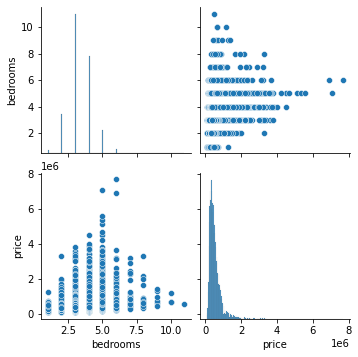

In [58]:
sns.pairplot(df.filter(['bedrooms','price']))

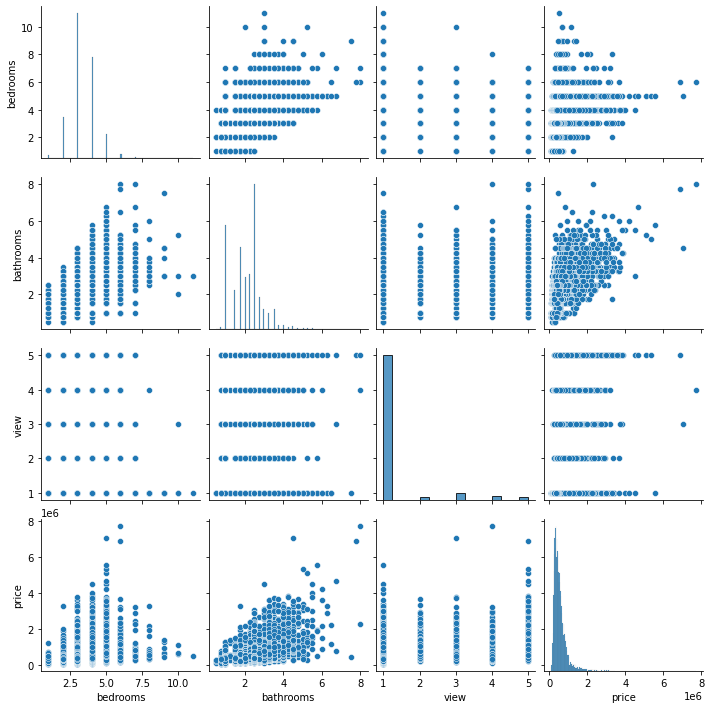

In [59]:
sns.pairplot(df_pairplotting1)

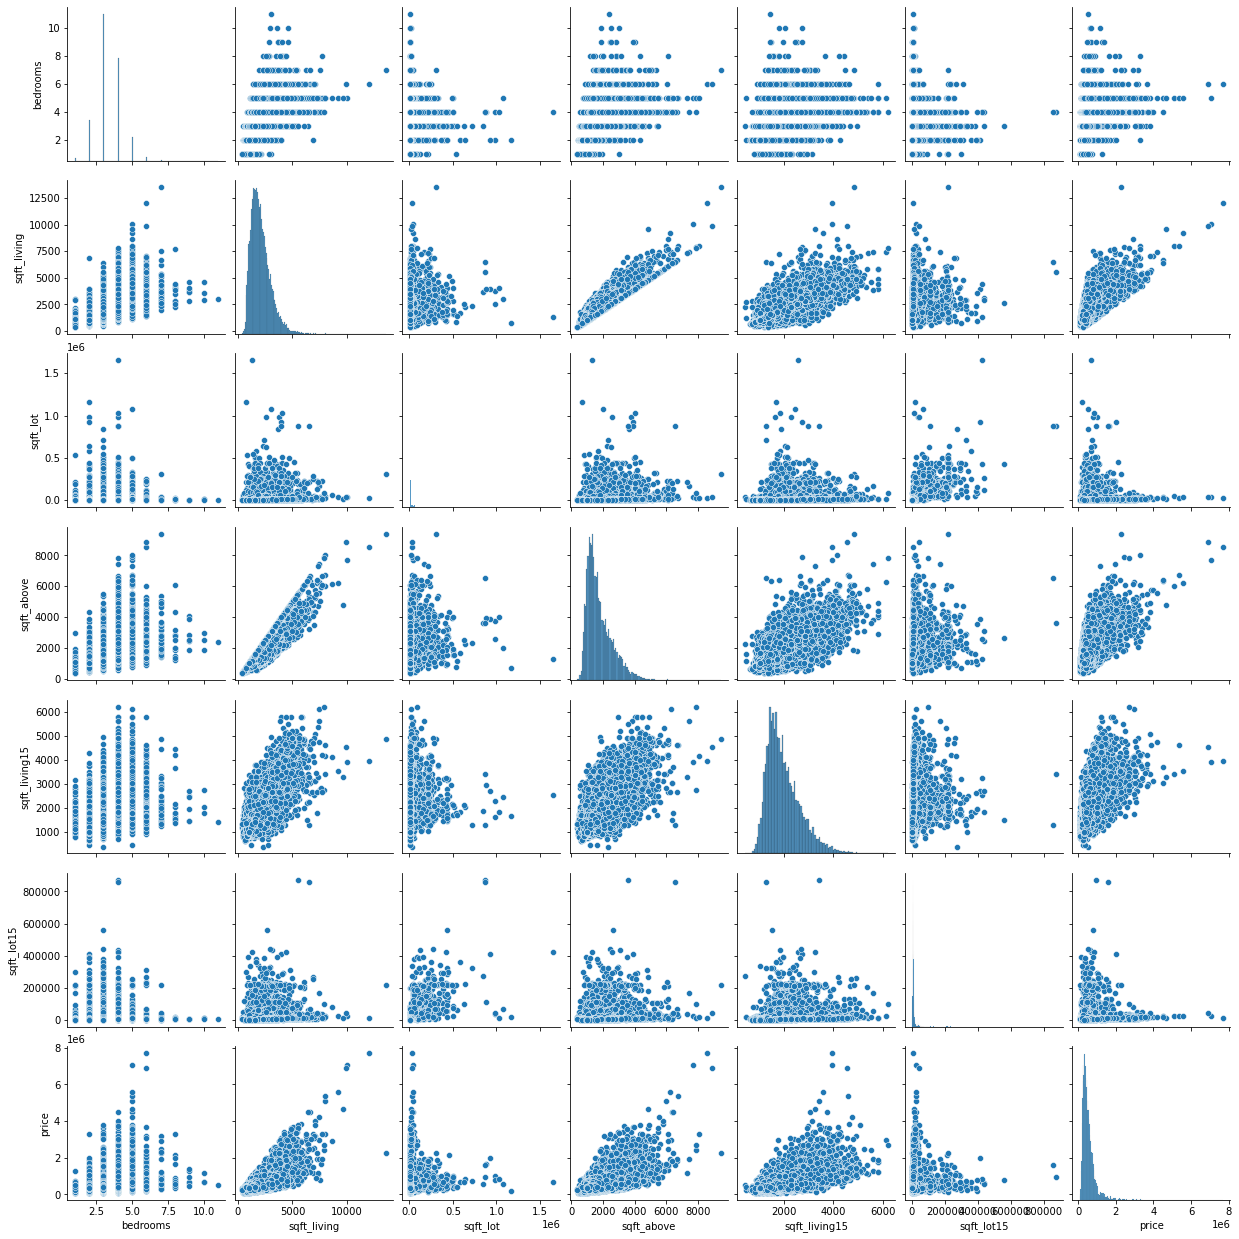

In [60]:
sns.pairplot(df_pairplotting2)